In [36]:
import pandas as pd
import numpy as np

# Import scaffoldgraph
import scaffoldgraph as sg

# Import networkx
import networkx as nx

# Import plotting tools
import matplotlib.pyplot as plt

# Import rdkit
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem import AllChem

from tqdm import tqdm
from IPython.display import Image
from IPython.core.display import HTML

from collections import defaultdict
import numpy as np

In [2]:
# function to get hierarchy 
def rearrange(data_dict, smiles):
    new_dict = {'smiles': smiles}
    new_dict.update(data_dict)
    return new_dict


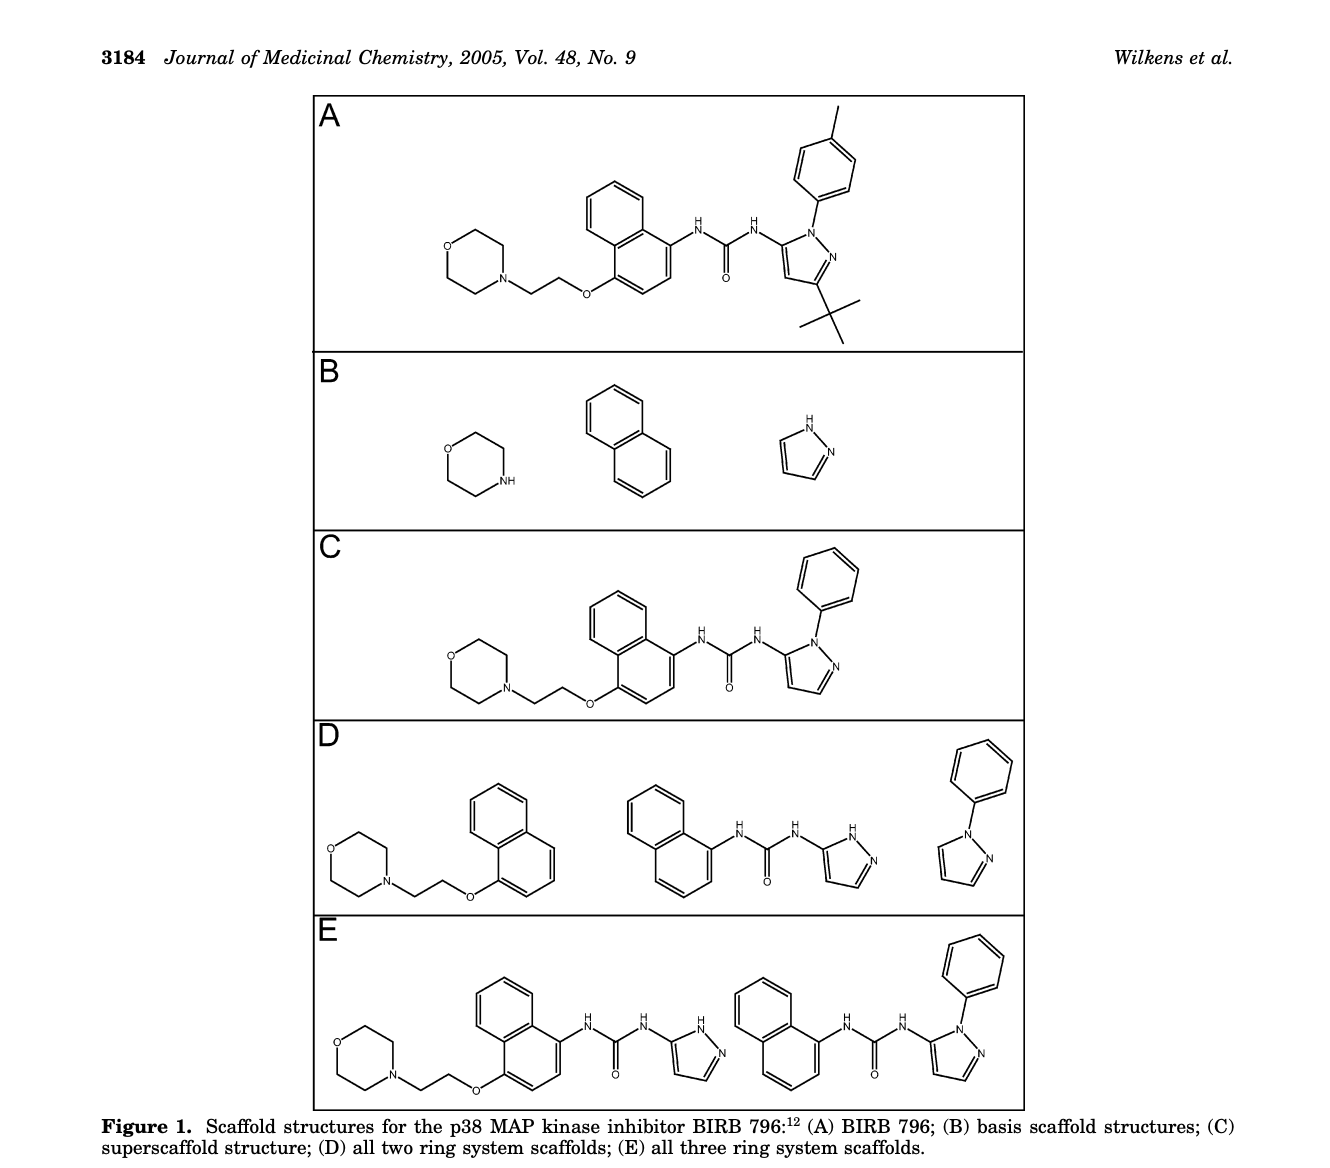

In [3]:
PATH = "/Users/criss/Desktop/"
Image(filename = PATH + "Screenshot 2023-05-05 at 11.26.22 AM.png", width=500, height=500)

In [4]:
df_network = pd.read_csv('deepchem-bace.csv')
# make canonicacl smiles just in case
df_network['smiles'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in tqdm(df_network.mol)]
# reorder to put molecules first
df_network = df_network[['smiles','CID','pIC50']]

100%|████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [00:00<00:00, 2924.14it/s]


In [5]:
# functions to clean bits up
def gen_scaffold_network(df, smiles_column='smiles', name_column='CID', data_columns='pIC50',method=str()):
    if method == 'ScaffoldNetwork':
        method = sg.ScaffoldNetwork
    else:
        method = sg.HierS
    network = method.from_dataframe(
    df, smiles_column=smiles_column, name_column=name_column,
    data_columns=[data_columns], progress=True)
    return network

def gen_scaffold_tree(df, smiles_column='smiles', name_column='CID', data_columns='pIC50'):
    tree = sg.ScaffoldTree.from_dataframe(
    df, smiles_column=smiles_column, name_column=name_column,
    data_columns=[data_columns], progress=True)
    return tree




In [6]:
# network = sg.HierS.from_dataframe(
#     df_network, smiles_column='smiles', name_column='CID',
#     data_columns=['pIC50'], progress=True,
# )

sg.ScaffoldNetwork.from_sdf(args, *kwargs)  

sg.ScaffoldNetwork.from_smiles_file(args, *kwargs)  

sg.Scaffoldnetwork.from_supplier(args, *kwargs) (custom molecule supplier)  

The ScaffoldNetwork generator breaks fused ring systems as per the definition in the original publication. If the user wants to preserve fused ring systems then they should use the sg.HierS class which functions in the same way as the ScaffoldNetwork class but does not break fused ring systems  



In [7]:
network = gen_scaffold_network(df_network,'smiles')

HierS:   0%|                                                                                              | 0/…

In [8]:
# We can access the number of molecule nodes and scaffold nodes in the graph
n_scaffolds = network.num_scaffold_nodes
n_molecules = network.num_molecule_nodes

print('\nGenerated scaffold network from {} molecules with {} scaffolds\n'.format(n_molecules, n_scaffolds))


Generated scaffold network from 1508 molecules with 1959 scaffolds



[(1, 99), (2, 457), (3, 680), (4, 531), (5, 172), (6, 17), (7, 3)]


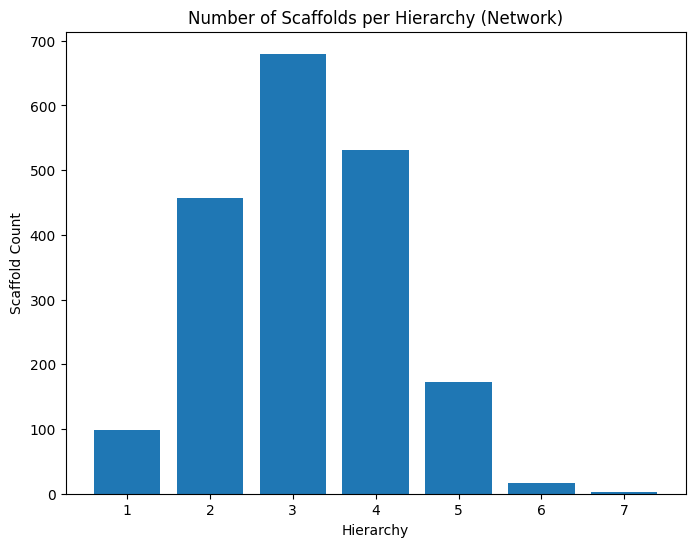

In [9]:
# We can get the number of scaffolds in each hierarchy easily

counts = network.get_hierarchy_sizes()  # returns a collections Counter object
lists = sorted(counts.items())
print(lists)
x, y = zip(*lists)

# Plot sizes as bar chart

plt.figure(figsize=(8, 6))
plt.bar(x, y)
plt.xlabel('Hierarchy')
plt.ylabel('Scaffold Count')
plt.title('Number of Scaffolds per Hierarchy (Network)')
plt.show()

In [10]:
#convert scaffold nodes with hierarchy information smiles and hierarchy  
data_dict =list(network.get_scaffold_nodes(data=True))
re_dict = [rearrange(tup,smi) for smi, tup in data_dict ]


In [11]:
re_dict[:7]

[{'smiles': 'O=C(CCc1cnc2ccc(-c3ccccc3)cc2c1)NC1CCOCC1',
  'type': 'scaffold',
  'hierarchy': 4},
 {'smiles': 'O=C(CCc1cnc2ccccc2c1)NC1CCOCC1',
  'type': 'scaffold',
  'hierarchy': 3},
 {'smiles': 'C1CCOCC1', 'type': 'scaffold', 'hierarchy': 1},
 {'smiles': 'c1ccc2ncccc2c1', 'type': 'scaffold', 'hierarchy': 2},
 {'smiles': 'c1ccc(-c2ccc3ncccc3c2)cc1', 'type': 'scaffold', 'hierarchy': 3},
 {'smiles': 'c1ccccc1', 'type': 'scaffold', 'hierarchy': 1},
 {'smiles': 'O=C(NC(Cc1ccccc1)CC1CCC[NH2+]1)C(CCc1ccccc1)N1CCCC1=O',
  'type': 'scaffold',
  'hierarchy': 4}]

In [12]:

network_df = pd.DataFrame.from_dict(re_dict)
hierarchies = sorted(network_df.hierarchy.unique())
print(f'{hierarchies}, this many hierarchies')
# create a dataframe for each hierarchy so we can if needed use later
for hs in hierarchies:
    hierarchy = network_df[network_df.hierarchy == hs]
    globals()[f'hierarchy_{hs}'] = network_df[network_df.hierarchy == hs]
network_df.head()

[1, 2, 3, 4, 5, 6, 7], this many hierarchies


,smiles,type,hierarchy
0,O=C(CCc1cnc2ccc(-c3ccccc3)cc2c1)NC1CCOCC1,scaffold,4
1,O=C(CCc1cnc2ccccc2c1)NC1CCOCC1,scaffold,3
2,C1CCOCC1,scaffold,1
3,c1ccc2ncccc2c1,scaffold,2
4,c1ccc(-c2ccc3ncccc3c2)cc1,scaffold,3


In [13]:
# doesnt work 
found_smiles = [] 
test = ['O=C(CCc1cnc2ccccc2c1)NC1CCOCC1']
for smi in test: #hierarchy_2.smiles:]
    network_df['exist'] = df_network['smiles'].map(lambda x: smi in x if x is not np.nan else False)
    print(network_df['exist'].sum())


0


In [14]:
# get an interesting smiles...
hierarchy_3['smiles'].iloc[0]

'O=C(CCc1cnc2ccccc2c1)NC1CCOCC1'

In [15]:
# try to get to work
BACE_id = list(network.get_molecule_nodes())

from collections import defaultdict
import numpy as np
rows = []
for ids in BACE_id:
    # per mole
    predecessors = nx.bfs_tree(network, ids, reverse=True)

    row = defaultdict(list)
    row['ID'] = ids
    for edge in predecessors.edges():
        #print(edge)
    # we need to get the edge attr from the original tree
        data = network.edges[edge[::-1]]
        
        if data['type'] == 0:  # molecule -> scaffold
            row['murcko scaffold'] = edge[-1]
            #print(data['annotation'])
            row['Annotation'].append(data['annotation'])
#         else:  # scaffold -> scaffold
#             row[data['annotation']].append(edge[-1])
    rows.append(row)
#     row['original'] = tree.nodes[list(predecessors)[0]]['smiles']
df = pd.DataFrame(data=rows)
df


,ID,murcko scaffold,Annotation
0,BACE_1,O=C(CCc1cnc2ccc(-c3ccccc3)cc2c1)NC1CCOCC1,[[1*]c1ccccc1-c1ccc2nc([2*])c(C[C@@H]([3*])C(=...
1,BACE_2,O=C(NC(Cc1ccccc1)CC1CCC[NH2+]1)C(CCc1ccccc1)N1...,[[1*][C@H]1C[NH2+][C@@H]([C@@H]([2*])[C@H](Cc2...
2,BACE_3,O=C(NC(CC[NH2+]Cc1ccccc1)Cc1ccccc1)c1cc2c3c(cc...,[[1*]c1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](...
3,BACE_4,O=S1(=O)CC(Cc2ccccc2)CC([NH2+]Cc2ccccc2)C1,[[1*]c1cc(C[C@@H]2CS(=O)(=O)C[C@H]([NH2+]Cc3cc...
4,BACE_5,O=C(NC(CC[NH2+]Cc1ccccc1)Cc1ccccc1)c1cc2c3c(cc...,[[1*]c1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](...
...,...,...,...
1503,BACE_1543,O=C(CCn1cnc2ccccc21)NCC1CCOCC1,[[1*]C(CC(=O)NCC1CCOCC1)n1c([2*])nc2cc([3*])cc...
1504,BACE_1544,O=C(CCn1cnc2ccccc21)NCc1ccccn1,[[1*]C(CC(=O)NCc1ccccn1)n1c([2*])nc2cc([3*])cc...
1505,BACE_1545,O=c1cc(C2CC2c2ccccc2)nc[nH]1,[[1*]n1c([2*])nc(C2CC2c2cccc([3*])c2)cc1=O]
1506,BACE_1546,O=c1cc(C2CC2c2cccc(-c3ccccc3)c2)nc[nH]1,[[1*]n1c([2*])nc(C2CC2c2cccc(-c3ccccc3)c2)cc1=O]


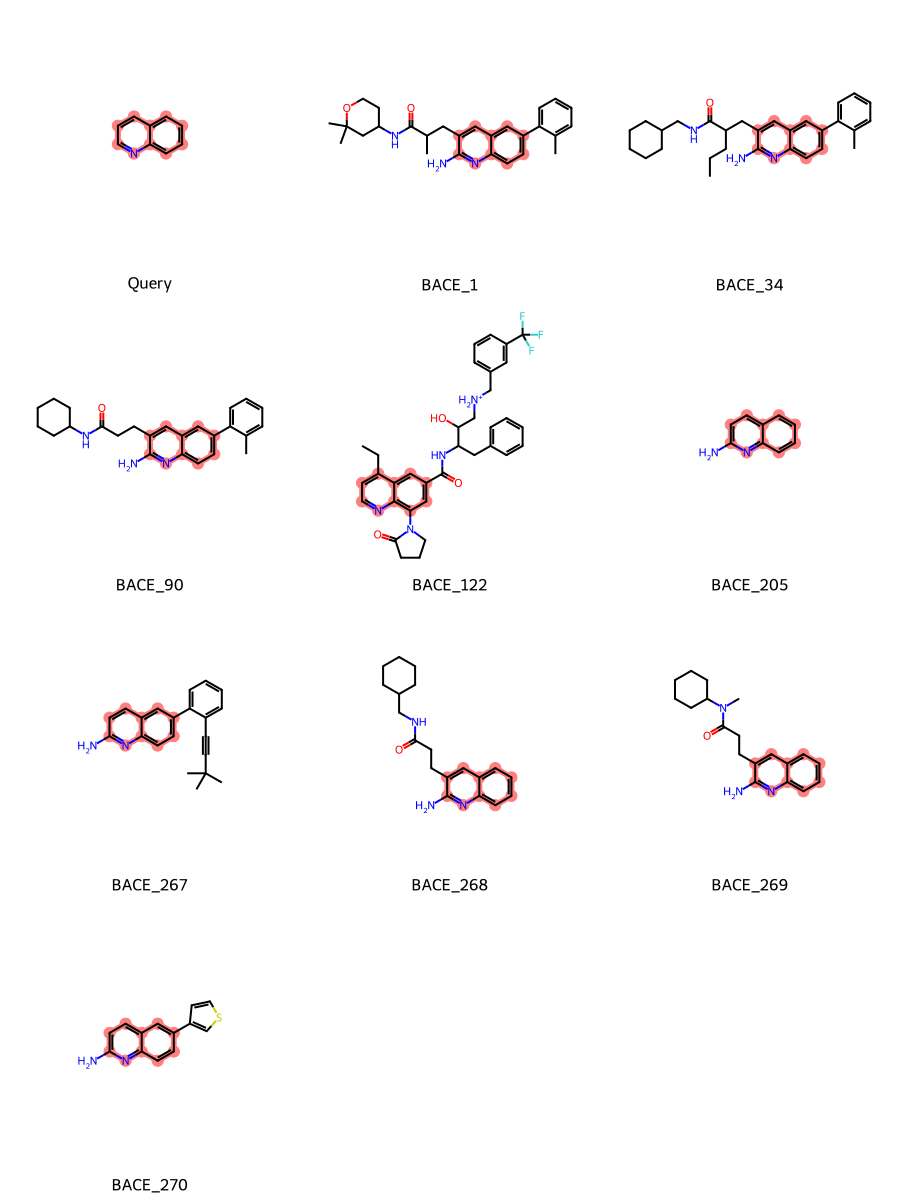

In [20]:
# find molecules that match the scaffold

from rdkit.Chem import AllChem
rdDepictor.SetPreferCoordGen(True)
match = []
IDS = []
query = Chem.MolFromSmiles(hierarchy_2['smiles'].iloc[0])
rdDepictor.Compute2DCoords(query)

match.append(query)
IDS.append('Query')

query_mols = [Chem.MolFromSmiles(smi) for smi in df_network['smiles']]
[Chem.RemoveStereochemistry( mol ) for mol in query_mols]
query_ID = [ID for ID in df.ID]
for mol, ID in zip(query_mols,query_ID):
    if mol.HasSubstructMatch(query):
        match.append(mol)
        rdDepictor.GenerateDepictionMatching2DStructure(mol, query)
        IDS.append(ID)

# draw a small sample
match = match[:10]
Draw.MolsToGridImage(match,highlightAtomLists=[ mol.GetSubstructMatch(query) for mol in match], 
                     useSVG=True,legends=IDS,subImgSize=(300, 300))



### generate scaffold tree
this seems to possibly be more useful

sg.ScaffoldTree.from_sdf(args, *kwargs)  
sg.ScaffoldTree.from_smiles_file(args, *kwargs)  
sg.ScaffoldTree.from_supplier(args, *kwargs) (custom molecule supplier)  

In [21]:
df_tree = pd.read_csv('deepchem-bace.csv')
df_tree['smiles'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in tqdm(df_tree.mol)]
df_tree = df_tree[['smiles','CID','pIC50']]



100%|████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [00:00<00:00, 2701.39it/s]


In [22]:
tree = gen_scaffold_tree(df_tree,'smiles')

ScaffoldTree:   0%|                                                                                       | 0/…

[(1, 118), (2, 267), (3, 429), (4, 402), (5, 171), (6, 17), (7, 3)]


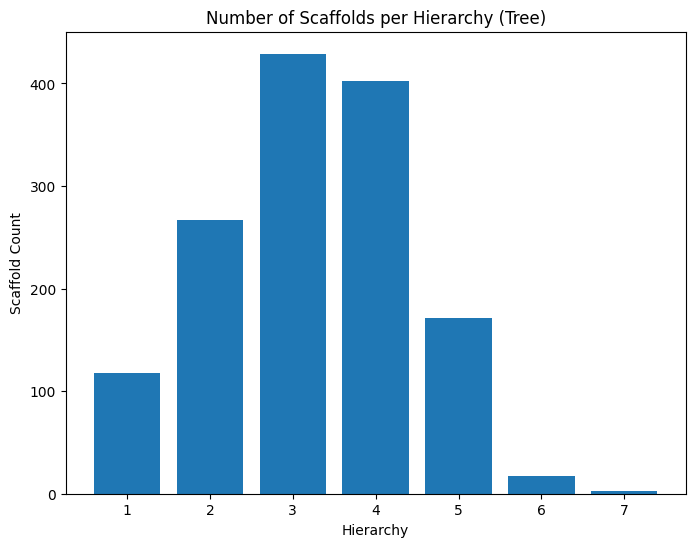

In [23]:
# We can get the number of scaffolds in each hierarchy easily

counts = tree.get_hierarchy_sizes()  # returns a collections Counter object
lists = sorted(counts.items())
print(lists)
x, y = zip(*lists)

# Plot sizes as bar chart

plt.figure(figsize=(8, 6))
plt.bar(x, y)
plt.xlabel('Hierarchy')
plt.ylabel('Scaffold Count')
plt.title('Number of Scaffolds per Hierarchy (Tree)')
plt.show()

In [26]:
# looping over each element e.g ID/Name 
BACE_id = list(tree.get_molecule_nodes())

rows = []
for ids in BACE_id:
    # per mole
    predecessors = nx.bfs_tree(tree, ids, reverse=True)
    row = defaultdict(list)
    row['ID'] = ids
    for edge in predecessors.edges():
    # we need to get the edge attr from the original tree
        data = tree.edges[edge[::-1]]
        if data['type'] == 0:  # molecule -> scaffold
            row['murcko scaffold'] = edge[-1]
        else:  # scaffold -> scaffold
            row[data['rule']].append(edge[-1])
    rows.append(row)
    row['original'] = tree.nodes[list(predecessors)[0]]['smiles'] # get original molecule
df = pd.DataFrame(data=rows)

df.count()

ID                   1508
murcko scaffold      1508
original rule 03     1144
original rule 08     1068
original             1508
original rule 06      112
original rule 13      333
original rule 05        5
original rule 04      166
last remaining         71
original rule 09b       1
original rule 10      128
original rule 02        3
original rule 11       91
original rule 09a      18
original rule 12        7
dtype: int64

In [30]:
print(len(df['murcko scaffold'].unique()))

670


In [31]:
query_collection = [x for x in df['original rule 03'].tolist() if str(x) != 'nan']
#query_collection = [x for x in df['original rule 10'].tolist() if str(x) != 'nan']
#query_collection = [x for x in df['original rule 08'].tolist() if str(x) != 'nan']
queries = [item for sublist in query_collection for item in sublist] # get all smiles as flat list
queries_unique = list(set(queries)) # list of unique smiles
print(f'Exists {len(queries)} and {len(queries_unique)} uninque smiles')


Exists 1668 and 477 uninque smiles


In [47]:
found_smiles = []

for smi in queries_unique:
    found = {}
    count_smiles = queries.count(smi)
    found['smiles'] = smi
    found['count'] = count_smiles
    found_smiles.append(found)
found_smiles = sorted(found_smiles,key=lambda x: x['count'], reverse=True)
# generate a sorted dataframe with most counts on top
df_scaff_freq = pd.DataFrame(data=found_smiles)

# display only scaffolds with 10 or more hits
df_scaff_freq.query('count >= 10').head(10)
# df_scaff_freq = df_scaff_freq.sort_values(['count'], ascending=False)
# df_scaff_freq

,smiles,count
0,O=S1(=O)CCCC(Cc2ccccc2)C1,58
1,c1cnc2c(c1)CCC1(CCC1)O2,54
2,O=C(NCc1ccccc1)c1ccccc1,48
3,c1ccc(C2CCCCC2)cc1,44
4,c1ccc2[nH]ccc2c1,43
5,C1=NC(c2ccccc2)CCO1,35
6,O=C1NC=NC12CCOc1ccccc12,32
7,C1=NCCc2ccccc21,31
8,c1ccc(Nc2ccccc2)cc1,31
9,c1ccc(-c2ccc(-c3ccccc3)[nH]2)cc1,29


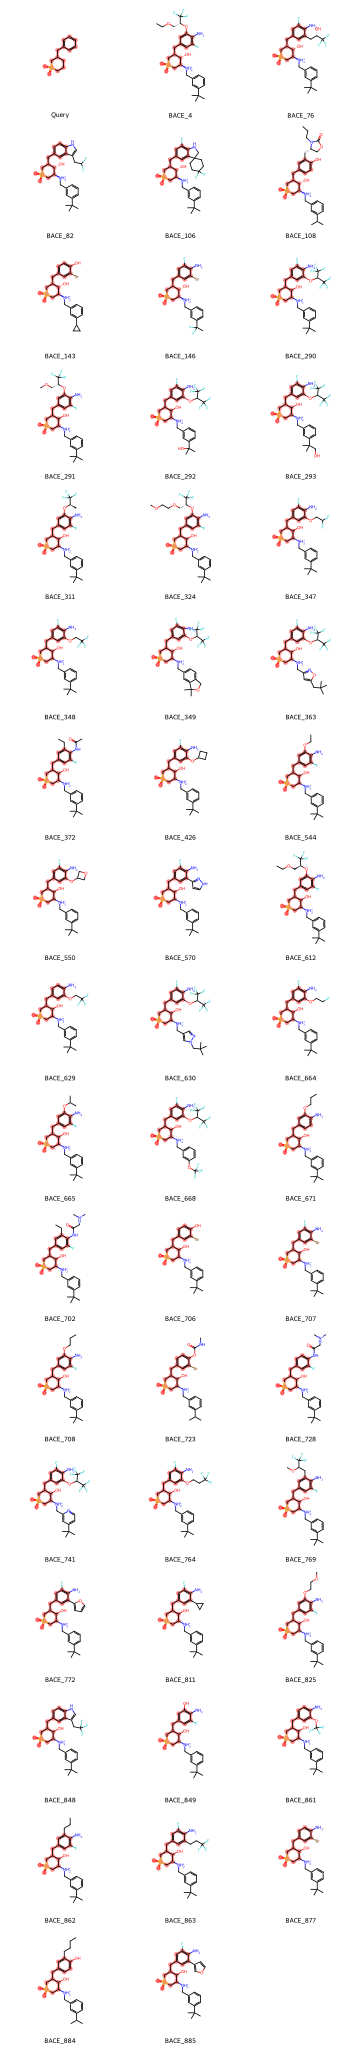

In [35]:
# find molecules that match the scaffold

from rdkit.Chem import AllChem
rdDepictor.SetPreferCoordGen(True)
match = []
IDS = []
query = Chem.MolFromSmiles(df_scaff_freq.smiles[0])
rdDepictor.Compute2DCoords(query)
match.append(query)
IDS.append('Query')

query_mols = [Chem.MolFromSmiles(smi) for smi in df['original']]
query_ID = [ID for ID in df.ID]
for mol, ID in zip(query_mols,query_ID):
    if mol.HasSubstructMatch(query):
        match.append(mol)
        rdDepictor.GenerateDepictionMatching2DStructure(mol, query)
        IDS.append(ID)
        
        
Draw.MolsToGridImage(match,highlightAtomLists=[ mol.GetSubstructMatch(query) for mol in match], 
                     useSVG=True,legends=IDS,subImgSize=(300, 300))



In [ ]:
df